In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter

# estilo de los gráficos
plt.style.use('ggplot')

In [3]:
def generar_dataset(n_muestras=1500, caja_centro=(-10, 10), semilla=None):
    np.random.seed(semilla)
    n_centros = np.random.randint(2, 10)
    distancia_min = 3.5
    centros = []
    intentos_max = 1000

    for _ in range(n_centros):
        intentos = 0
        while intentos < intentos_max:
            candidato = np.random.uniform(caja_centro[0], caja_centro[1], size=(2,))
            if not centros:
                centros.append(candidato)
                break
            distancias = [np.linalg.norm(candidato - centro) for centro in centros]
            if min(distancias) >= distancia_min:
                centros.append(candidato)
                break
            intentos += 1
        if intentos == intentos_max:
            distancia_min *= 0.9
            centros.append(np.random.uniform(caja_centro[0], caja_centro[1], size=(2,)))

    centros = np.array(centros)
    desviaciones = np.random.uniform(0.3, 0.7, size=n_centros)
    X, y = make_blobs(n_samples=n_muestras, centers=centros, cluster_std=desviaciones, random_state=semilla)
    return X, y, centros


In [4]:
def graficar_datos(X):
    plt.figure(figsize=(8, 5))
    plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.6, color='teal')
    plt.title("visualización del dataset original")
    plt.xlabel("característica 1")
    plt.ylabel("característica 2")
    plt.grid(True)
    plt.show()

def graficar_centroides(centros):
    plt.scatter(centros[:, 0], centros[:, 1], c='red', s=120, alpha=0.9, marker='x', label='centroides')
    plt.legend()

def graficar_clusters(X, y, centros):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Accent', s=10)
    plt.scatter(centros[:, 0], centros[:, 1], c='black', s=200, alpha=0.6, marker='o', edgecolors='red', linewidths=2)
    plt.xlabel("característica 1")
    plt.ylabel("característica 2")
    plt.title("agrupamiento con k-means")
    plt.grid(True)

def graficar_fronteras(modelo, X, res=800):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, res), np.linspace(y_min, y_max, res))
    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)


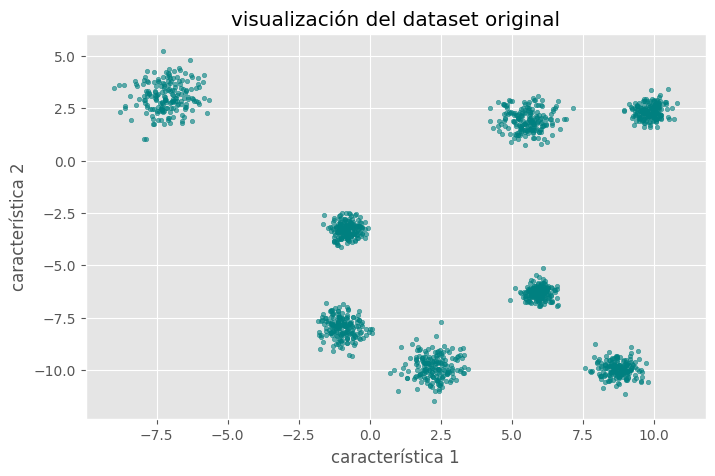

coordenadas de los centroides generados:
[[ 5.93085974 -6.3313042 ]
 [ 5.59382001  1.93700316]
 [-1.08334494 -8.00050168]
 [-0.81502216 -3.32582778]
 [-7.14266364  3.01776946]
 [ 8.77105418 -9.98442468]
 [ 9.84423119  2.34963019]
 [ 2.23306321 -9.8586739 ]]


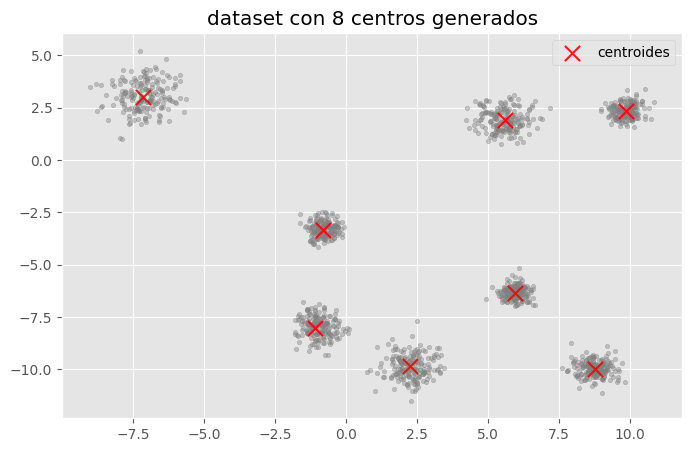

In [5]:
X, y_verdadero, centros = generar_dataset(n_muestras=1500, semilla=42)
graficar_datos(X)

print("coordenadas de los centroides generados:")
print(centros)

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=10, color='gray', alpha=0.4)
graficar_centroides(centros)
plt.title(f"dataset con {len(centros)} centros generados")
plt.show()


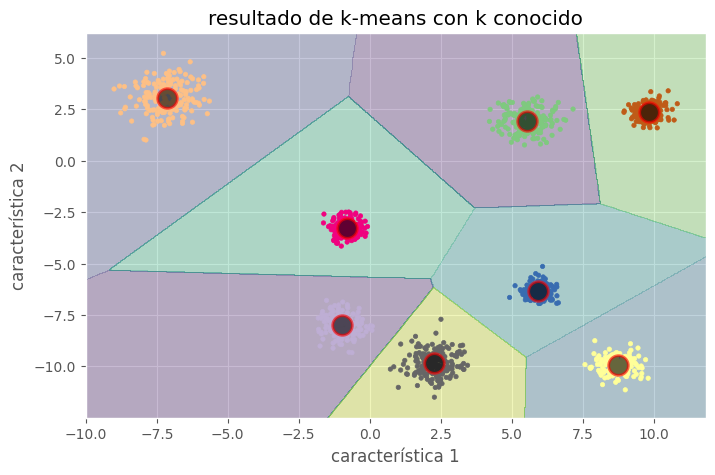

In [8]:
modelo_kmeans = KMeans(n_clusters=len(centros), random_state=42, n_init=10)
y_pred = modelo_kmeans.fit_predict(X)

plt.figure(figsize=(8, 5))
graficar_fronteras(modelo_kmeans, X)
graficar_clusters(X, y_pred, modelo_kmeans.cluster_centers_)
plt.title("resultado de k-means con k conocido")
plt.show()


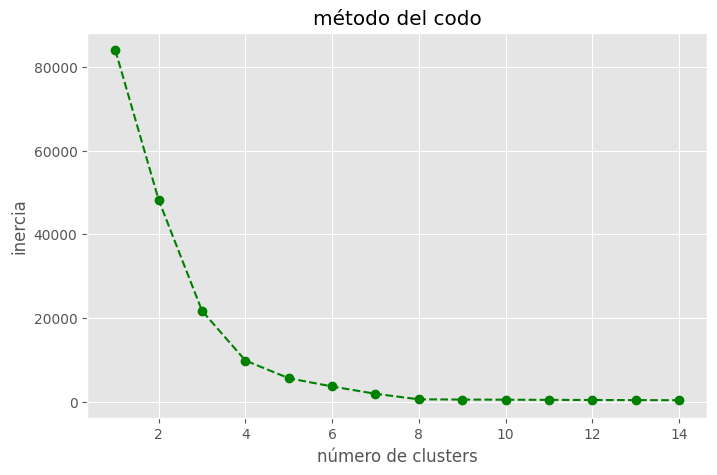

In [10]:
rangos_k = range(1, 15)
inercia = []

for k in rangos_k:
    modelo = KMeans(n_clusters=k, random_state=42, n_init=10)
    modelo.fit(X)
    inercia.append(modelo.inertia_)  # <-- corregido aquí

plt.figure(figsize=(8, 5))
plt.plot(rangos_k, inercia, 'go--')
plt.xlabel("número de clusters")
plt.ylabel("inercia")
plt.title("método del codo")
plt.grid(True)
plt.show()


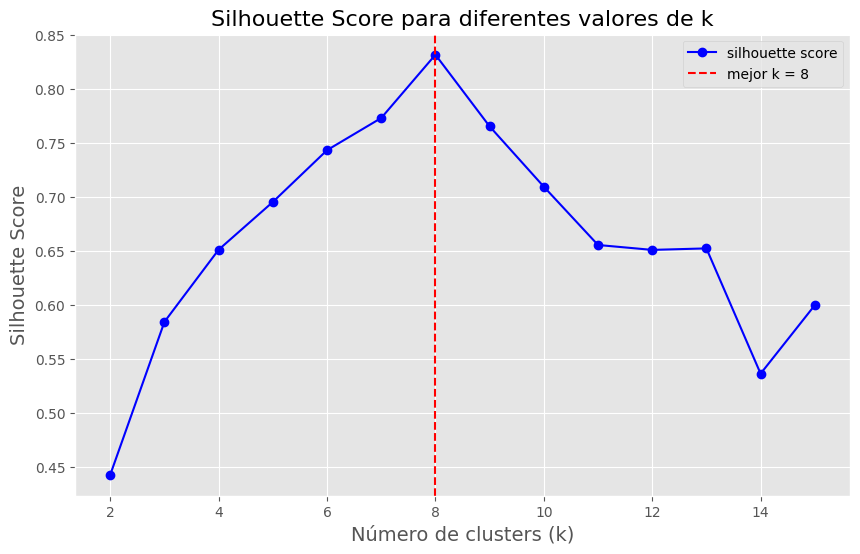

In [11]:
# PARTE: SILHOUETTE SCORE PARA DIFERENTES 

from sklearn.metrics import silhouette_score

k_range = range(2, 16)  # usualmente empieza en 2 porque k=1 no tiene sentido para silhouette
silhouette_scores = []

for k in k_range:
    modelo = KMeans(n_clusters=k, random_state=42, n_init=10)
    modelo.fit(X)
    score = silhouette_score(X, modelo.labels_)
    silhouette_scores.append(score)

# mejor k según silhouette
optimal_k = k_range[np.argmax(silhouette_scores)]

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-', label='silhouette score')
plt.xlabel("Número de clusters (k)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.title("Silhouette Score para diferentes valores de k", fontsize=16)
plt.grid(True)
plt.axvline(optimal_k, color='red', linestyle='--', label=f'mejor k = {optimal_k}')
plt.legend()
plt.show()


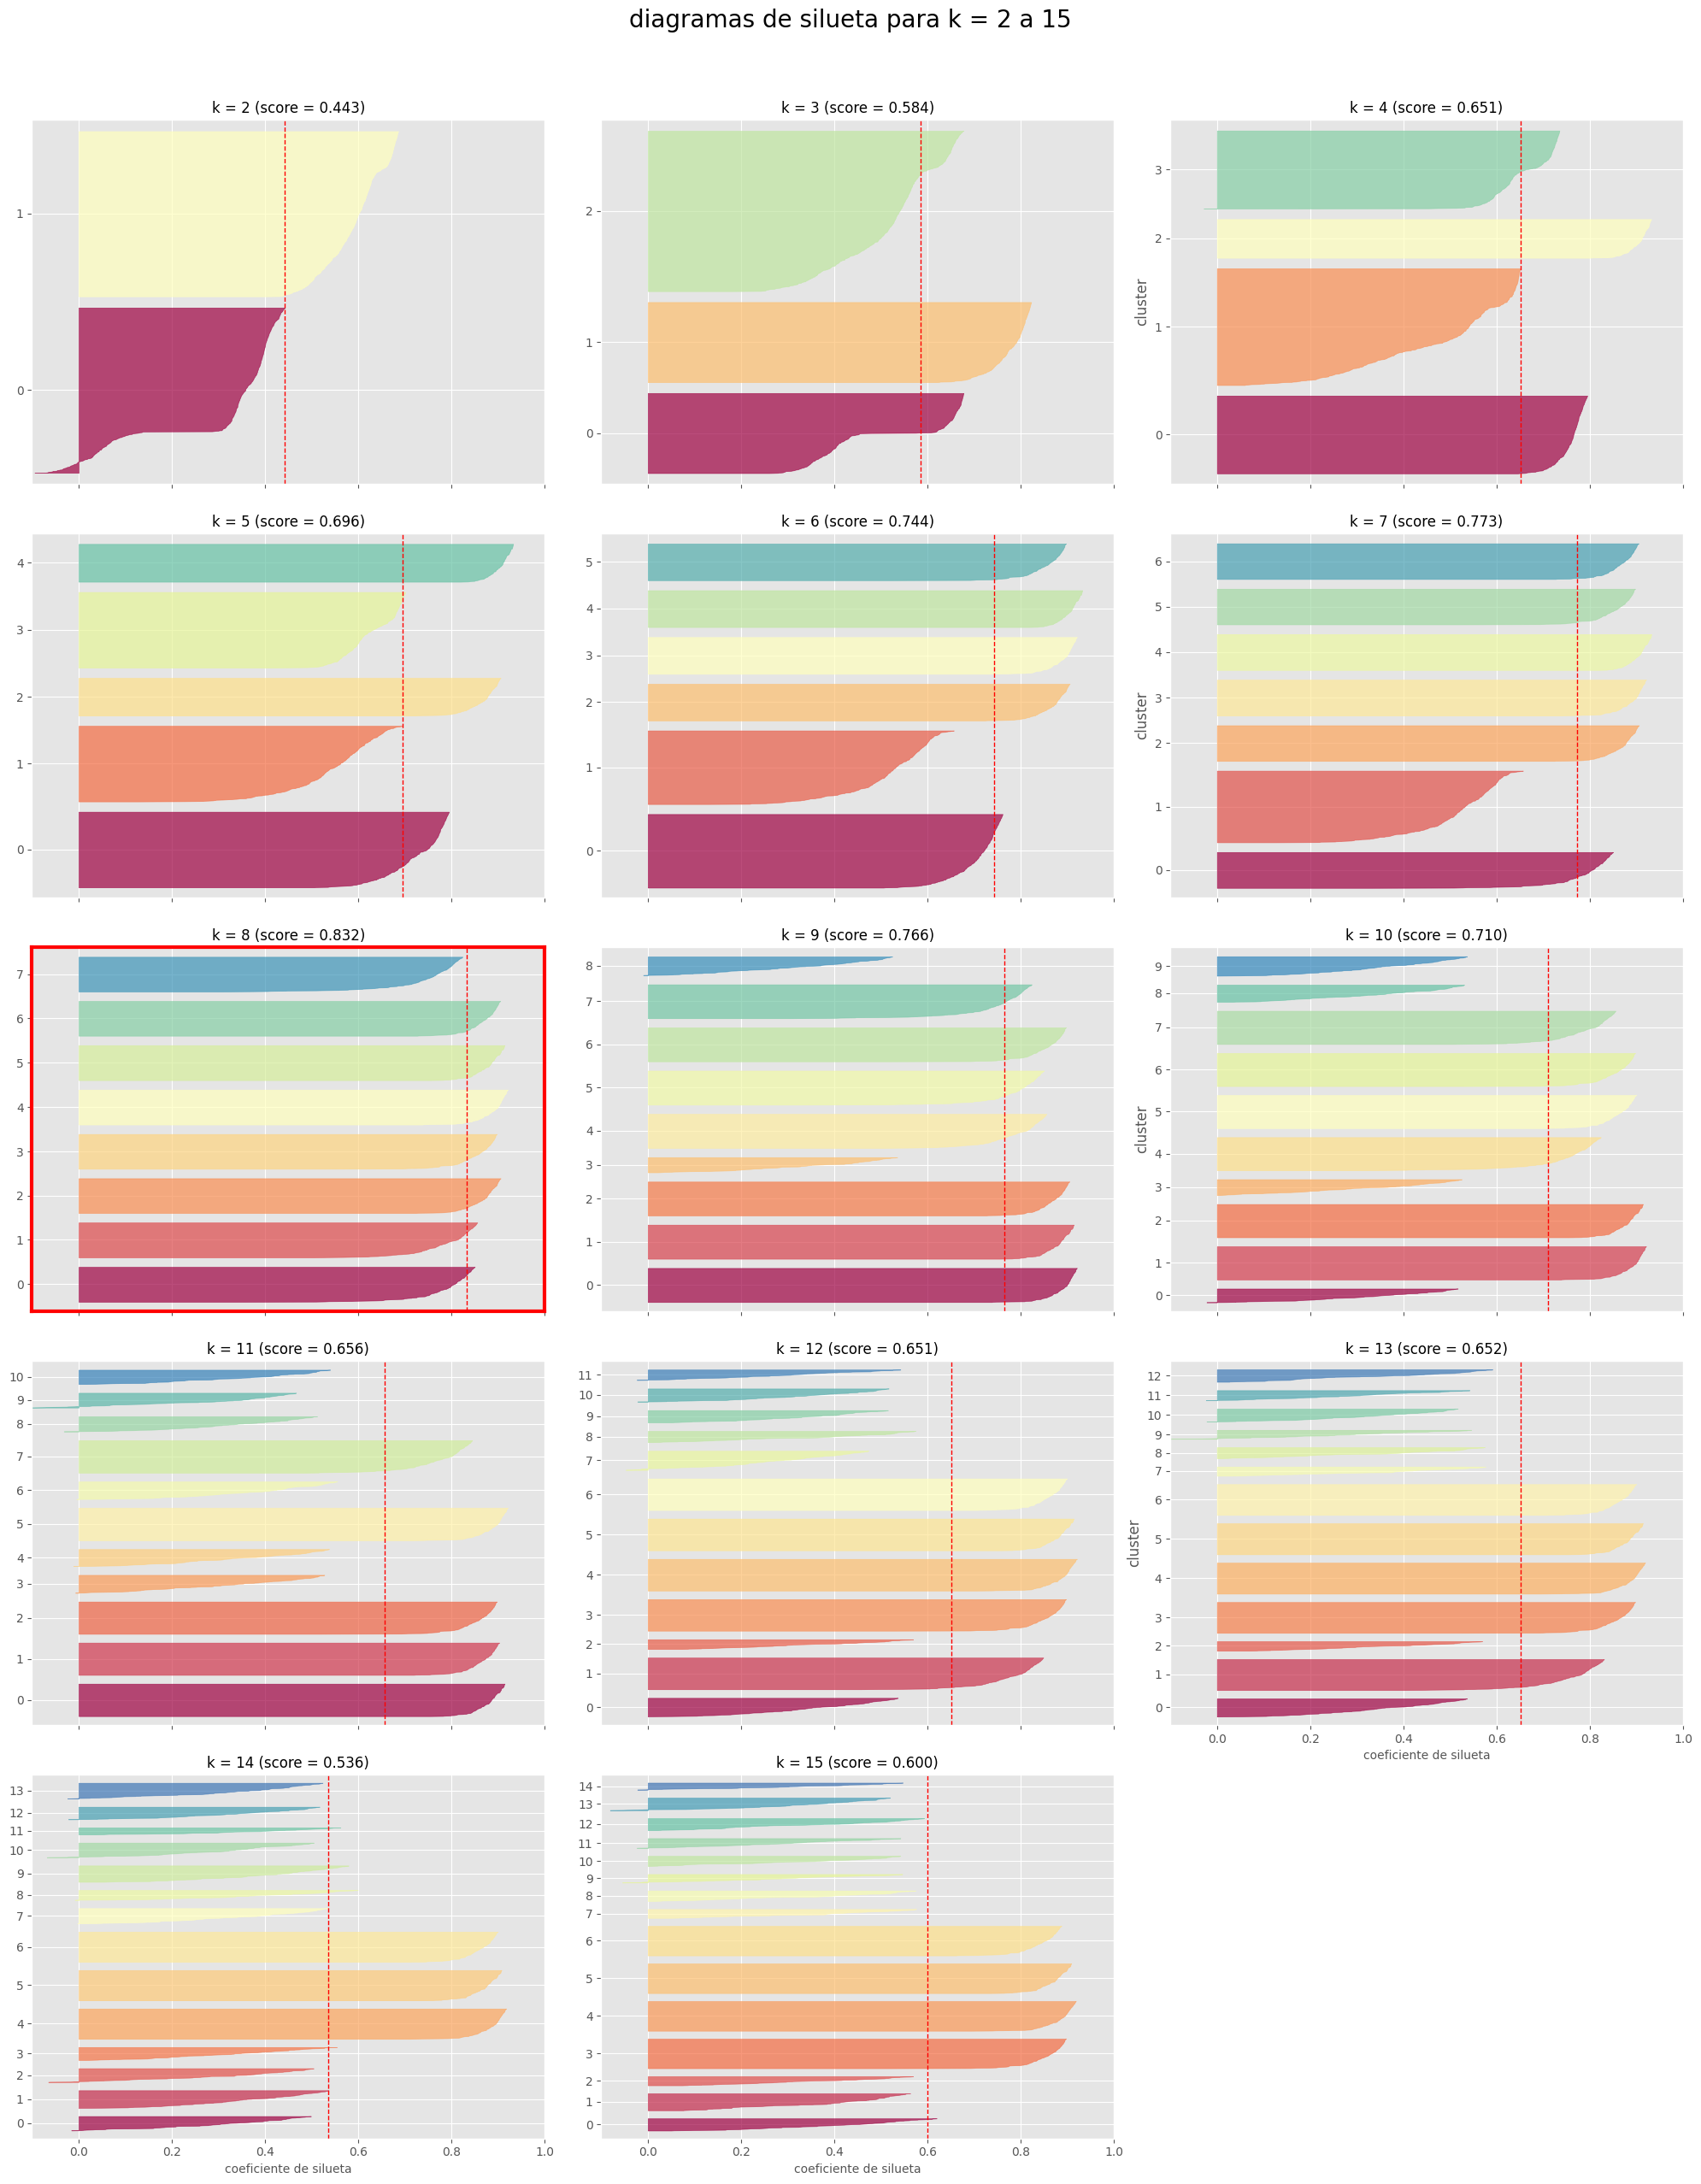

In [12]:

import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import silhouette_samples

plt.figure(figsize=(20, 25))
plt.suptitle("diagramas de silueta para k = 2 a 15", fontsize=20, y=1.02)

for k in range(2, 16):
    plt.subplot(5, 3, k-1)
    modelo = KMeans(n_clusters=k, random_state=42, n_init=10)
    y_pred = modelo.fit_predict(X)
    silhouette_coeffs = silhouette_samples(X, y_pred)
    padding = len(X) // 30
    pos = padding
    ticks = []

    for j in range(k):
        coeffs = silhouette_coeffs[y_pred == j]
        coeffs.sort()
        color = mpl.cm.Spectral(j / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if (k-1) % 3 == 0:
        plt.ylabel("cluster", fontsize=12)
    plt.axvline(x=silhouette_scores[k-2], color="red", linestyle="--", linewidth=1)
    if k == optimal_k:
        for spine in plt.gca().spines.values():
            spine.set_color('red')
            spine.set_linewidth(3)
    plt.title(f"k = {k} (score = {silhouette_scores[k-2]:.3f})", fontsize=12)
    plt.xlim(-0.1, 1)
    plt.ylim(0, pos)
    if k > 12:
        plt.xlabel("coeficiente de silueta", fontsize=10)
    else:
        plt.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()
